Augmentations became a necessary part of many computer vision pipelines. However, in other domains they still are not as popular as in CV. In this article, I will review time series augmentations and provide examples of their usage with a library for generative time series modeling TSGM.

A dataset $(X, y)$ is given. Here, $x_i \in X$ are multivariate (meaning, each time point is a multiple dimensional feature vector) time series, and y are labels. We will call this the downstream task. Our goal is using $(X, y)$ to produce additional samples $(\hat{X}, \hat{y})$ which could help us solve the downstream task more effectively (in terms of predictive performance or robustness).

Without further ado, let’s consider time series augmentations one by one.
In TSGM, all augmentations are stored in tsgm.models.augmentations, and you can read documentation about them in TODO:add link


To kick start coding examples, we need to install tsgm:
```bash
pip install tsgm
```

Next we import tsgm, and load an exemplary dataset. Tensor X now contains 100 sine time series of length 64, with 2 features each. With random shift, frequencies, and amplitudes (maximum amplitude is 20).

In [78]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display, Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import tsgm


def plot(timesteps, X, plot_id=1, title="Original"):
    plt.subplot(1, 2, plot_id)
    for sample_id in range(X.shape[0]):
        plt.plot(timesteps, X[sample_id, :, 0], label=f"Sample #{sample_id}")
    plt.title(title)
    plt.legend()


def plot_samples_aug(X, Xaug, n_samples=5):
    timesteps = np.arange(0, X.shape[1], 1)
    sample_ids = random.sample(range(X.shape[0]), n_samples)
    sample_ids_aug = random.sample(range(Xaug.shape[0]), n_samples)

    plot(timesteps, X[sample_ids])
    plot(timesteps, Xaug[sample_ids_aug], title="Augmented", plot_id=2)
    plt.show()
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
X = tsgm.utils.gen_sine_dataset(100, 64, 2, max_value=20)

## Jittering / Gaussian noise

Time series data are augmented with random Gaussian noise ([Wikipedia](https://en.wikipedia.org/wiki/Gaussian_noise))

$$x_i = x_i + \mathcal{N}(0, \sigma).$$

In tsgm, it Gaussian noise augmentation can be used as follows:


In [54]:
aug_model = tsgm.models.augmentations.GaussianNoise(variance=0.2)
samples = aug_model.generate(X=X, n_samples=10)

The idea behind Gaussian noise augmentation is that adding a small amount of jittering to time series probably will not change it significantly but will increase the amount of such noisy samples in our dataset. It often makes the downstream models more robust to noisy samples or improves predictive performance.

The hyperparameters of Gaussian noise and the way of adding it (e.g., Gaussian noise can increase towards the end of time series) is a difficult question and depends on a particular dataset and downstream problem.

Here we provide a visualization of the samples from the original sine dataset and augmented samples.

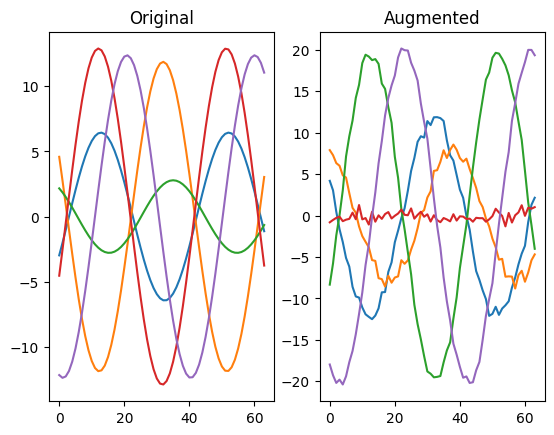

In [55]:
plot_samples_aug(X, samples)

## Shuffle Features

Another approach to time series augmentation is simply shuffly the features. This approach is suitable only for particular multivariate time series, where they are invariant to all or particular permutations of features. For instance, it can be applied to time series where each feature represents same independent measurements from various sensors. 

In following example, we have 5 identical sensors ($S_1, S_2, S_3, S_4, \text{and } S_5$). We can see that sensors 1-4 are probably exchangeable with respect to rotation. Then it makes sense to try augmenting data with feature shufle with respect to rotations of $S_1, \ldots, S_4$ sensors.

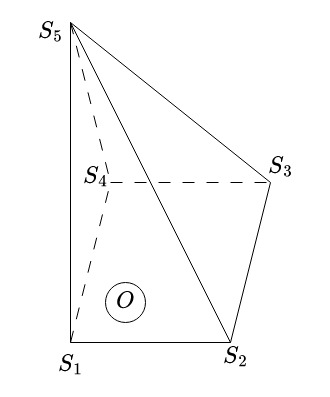

In [25]:
Image("./images/shuffle_features.jpg", height=256, width=256)

Similarly to previous example, the augmentation can work as follows:

In [69]:
aug_model = tsgm.models.augmentations.Shuffle()
samples = aug_model.generate(X=X, n_samples=3)

Here, we see one sample from a timeseries with 5 features, and an augmented sample, generated with time series augmentation. Analogously to the image above.

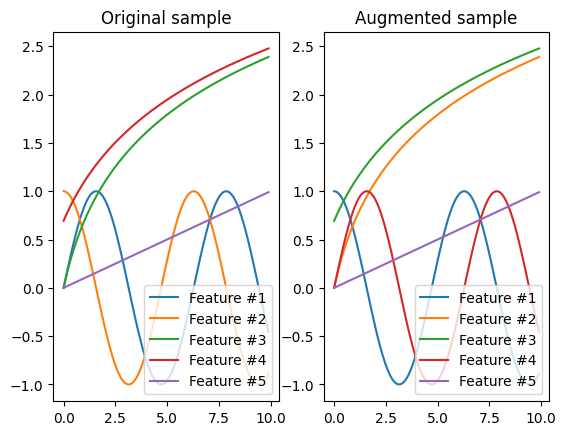

In [70]:
timesteps = np.arange(0, 10, 0.1)
sample = np.stack([np.sin(timesteps), np.cos(timesteps), np.log(timesteps + 1), np.log(timesteps + 2), timesteps / 10])
plt.subplot(1, 2, 1)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Original sample")
plt.legend()

permutation = [1, 2, 3, 0, 4]
sample = sample[permutation]
plt.subplot(1, 2, 2)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Augmented sample")
plt.legend()
plt.show()

## Slice and shuffle

Um TT, Pfister FM, Pichler D, Endo S, Lang M, Hirche S,
Fietzek U, Kulic´ D (2017) Data augmentation of wearable
sensor data for parkinson’s disease monitoring using convolu-
tional neural networks. In: Proceedings of the 19th ACM
international conference on multimodal interaction, pp. 216–220

Slice and shuffle augmentation cuts a time series into slices and shuffles those pieces. This augmentation can be performed for time series that exhibit some form of invariance over time. For instance, imagine time series measured from wearable devices for several days. The good strategy for this case is slice time series by days and by shuffling those days get additional samples. Slice and shuffle augmentation is visualized in the following image:

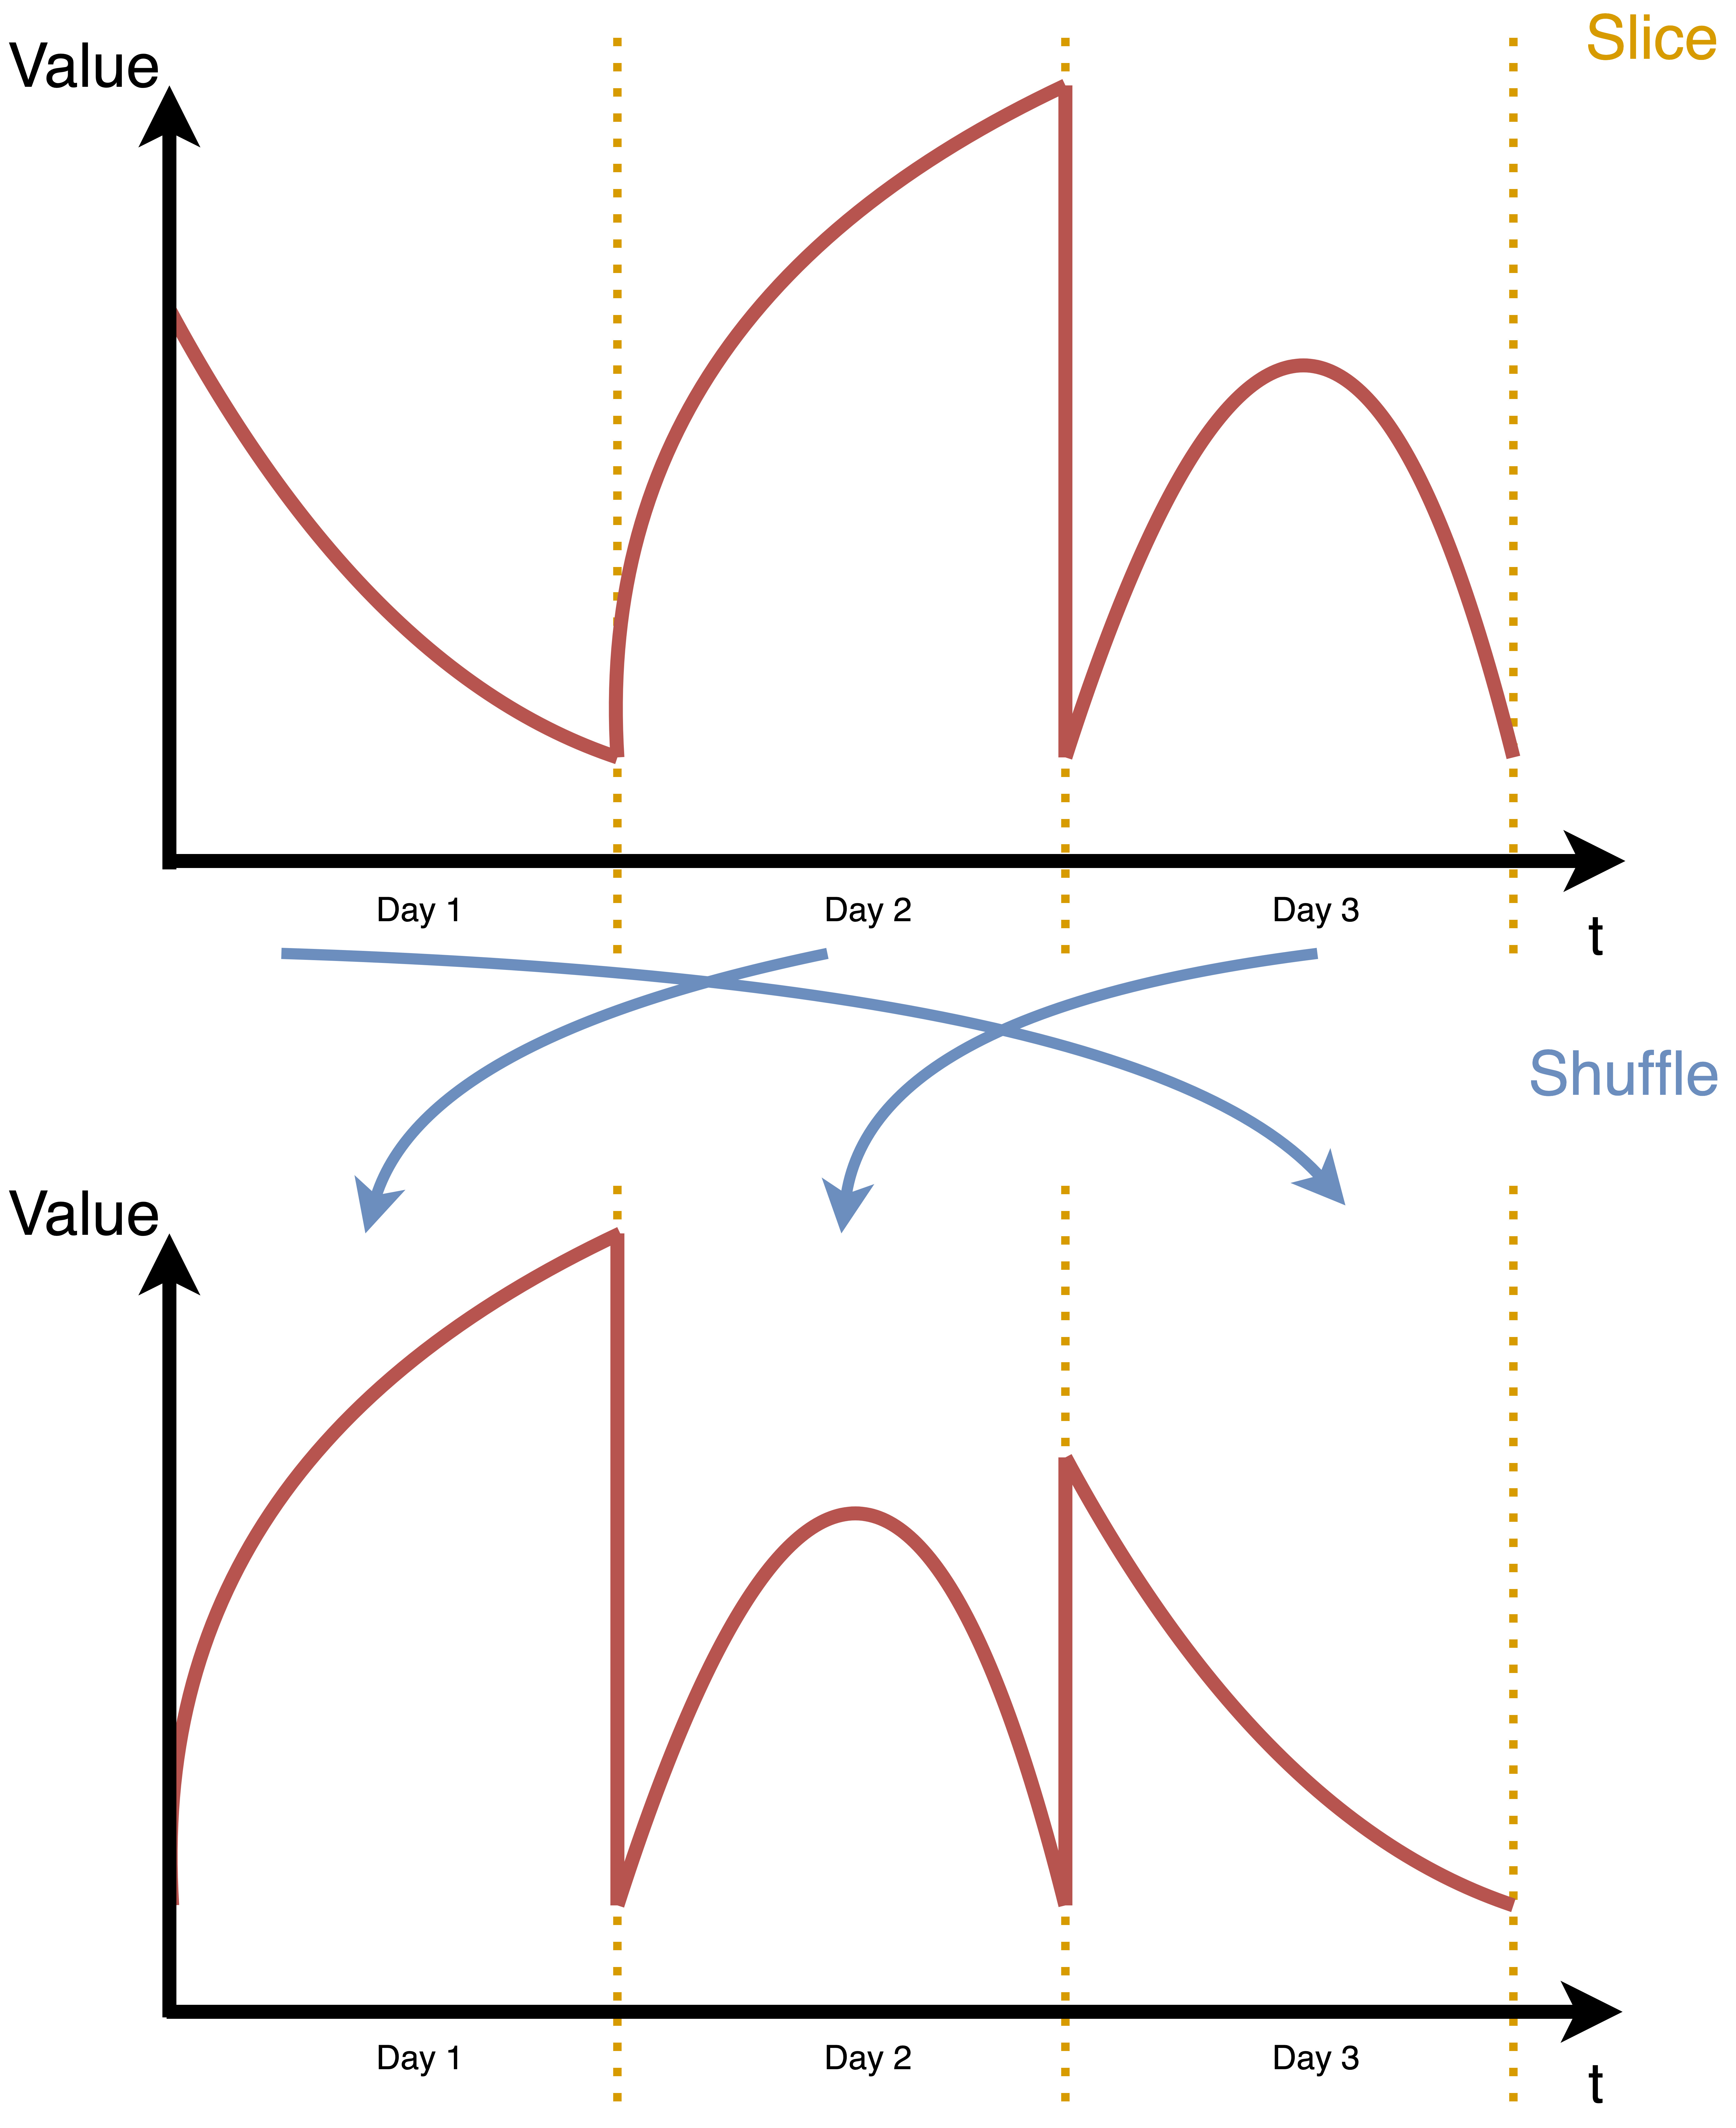

In [71]:
Image("./images/slice_and_shuffle.jpg", height=1024, width=512)

In [76]:
aug_model = tsgm.models.augmentations.SliceAndShuffle(n_segments=3)
samples = aug_model.generate(X=X, n_samples=10)

Let's view augmented and original samples as a visualization:

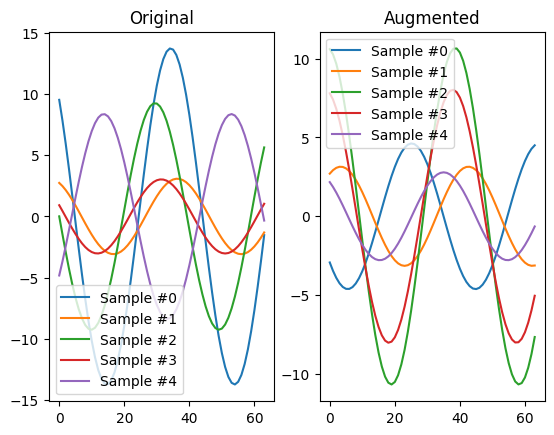

In [79]:
plot_samples_aug(X, samples)

## Magnitude Warping

Magnitude warping changes the magnitude of each samples in time series dataset by multiplication of the original time series with a curve cubic spline curve with `n_knots` number of knots at random magnitudes distributed as $\mathcal{N}(1, \sigma)$ where $\sigma$ is set by a parameter `sigma` in function `.generate`.

In [84]:
aug_model = tsgm.models.augmentations.MagnitudeWarping()
samples = aug_model.generate(X=X, n_samples=10, sigma=1)

Here is an example of original data and augmented samples generated with MagnitudeWarping.

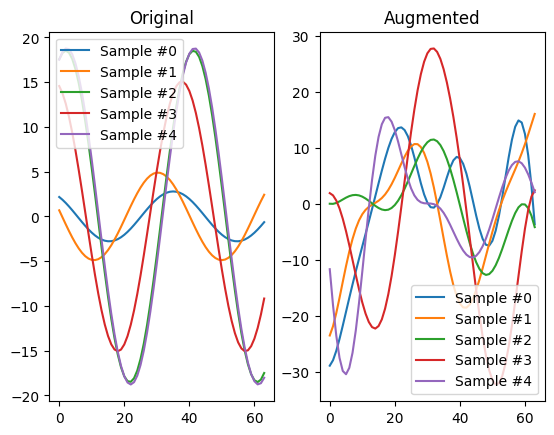

In [85]:
plot_samples_aug(X, samples)

## Window Warping

Rashid, K.M. and Louis, J., 2019. Window-warping: a time series data augmentation of IMU data for construction equipment activity identification. In ISARC. Proceedings of the international symposium on automation and robotics in construction (Vol. 36, pp. 651-657). IAARC Publications.

In this technique, the selected windows in time series data are either speeding up or speeding down. Then the whole resulting time series is scaled back to the original size in order to keep the timesteps at the original length. See an example of such augmentation below:

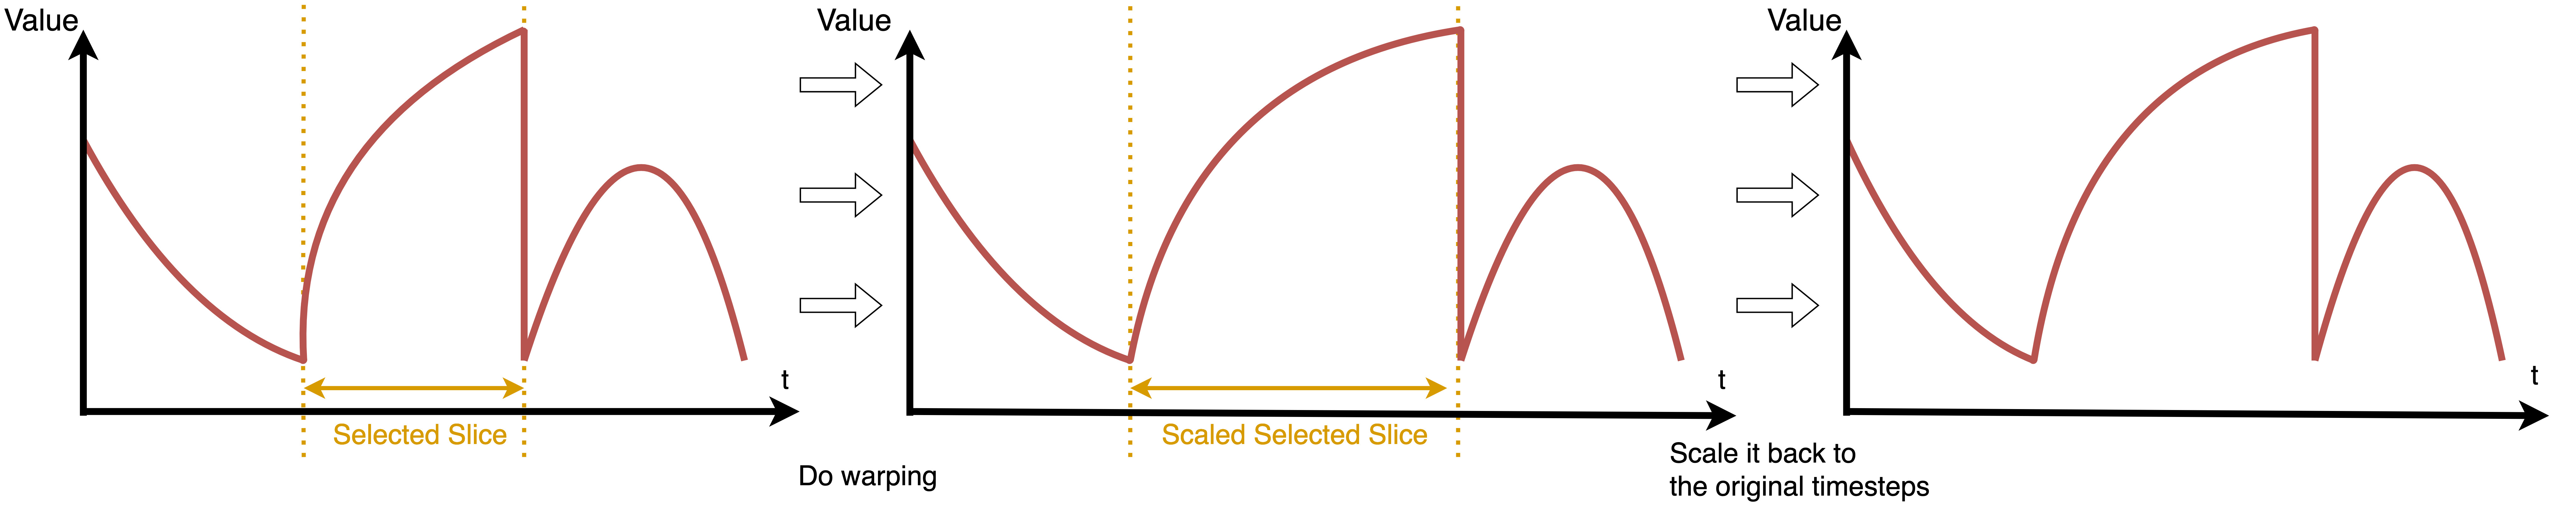

In [86]:
Image("./images/window_warping.jpg", height=512, width=1024)

Such augmentation can be beneficial, e.g., in modeling equipment. In such application sensor measurements can change the speed of change and depending on how those pieces of equipment are used.


In tsgm, as always the generation can be done via

In [93]:
aug_model = tsgm.models.augmentations.WindowWarping()
samples = aug_model.generate(X=X, n_samples=10, scales=(0.5,), window_ratio=0.5)

And an example of generated time series can be viewed below

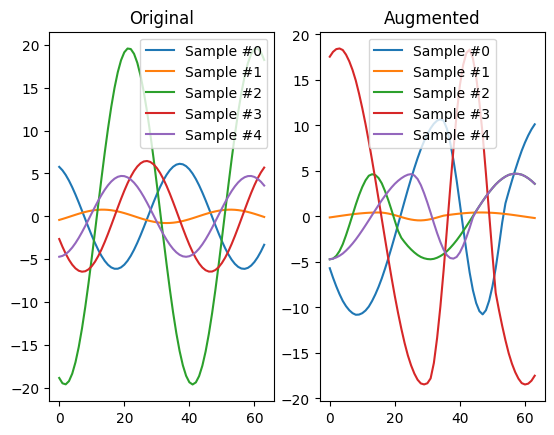

In [94]:
plot_samples_aug(X, samples)

## Dynamic Time Warping Barycentric Average (DTWBA)